# Basic case

In [1]:
import numpy as np
from numba import njit


def met_tmp(lat, T = 0.0):
    N = lat.shape[0]
    n = 0
    while n < N**2:
        i,j = np.random.randint(0, N, size=2)
        delta_E = get_delta_E(i,j,lat)
        if T ==0.0:
            if delta_E <=0:
                lat[i,j] *=-1
        else:
            w = np.exp(-delta_E / T)
            r = np.random.uniform(0.,1.)
            if w>r:
                lat[i,j] *= -1
        n += 1
    
    

@njit
def get_delta_E(i, j, lat):
    
    nx, ny = lat.shape  # Original number of points along each direction
    sp = lat[i, j]

    i_1 = (i-1)%nx
    i_2 = (i+1)%nx
    j_1 = (j + 1) % ny  # PBC y-dir
    j_2 = (j - 1) % ny # PBC y-dir
    
    sum_other = lat[i_1, j] + lat[i_2, j] + lat[i, j_1] + lat[i, j_2]

    return 2 * sp * sum_other  # Difference in energy when flipping


# Mon Jasnow 
---

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import palettable as pl
emr = pl.cartocolors.sequential.Emrld_7_r.get_mpl_colormap()

In [4]:
from mon_jasnow import ising_hamiltonian, metropolis_subroutine, metropolis_MJ
from lattice_utils import get_lattice_pp,get_lattice_pm, convert_pp_to_pm, energy_diff, get_flip_energy

In [5]:
N = 20
T = 0.1
%time la_pp = get_lattice_pp(N)
init_lattice = la_pp.copy()

Wall time: 1.15 s


In [9]:
# Check that energy diff function returns the same as the difference in hamiltonians
la_pp = get_lattice_pp(N)

for i in range(1000):
    i,j = np.random.randint(0, N, size=2) +[1, 0]
    tmp = la_pp.copy()
    tmp[i,j] *= -1
    ed = get_flip_energy(i,j,la_pp)
    ed2 = ising_hamiltonian(tmp) - ising_hamiltonian(la_pp)
    metropolis_subroutine(la_pp, T)
    if ed != ed2:
        print(i,j,ed, ed2, la_pp.shape[0])

In [14]:
%%time
for _ in range(200): # N_sweeps
    metropolis_subroutine(la_pp, T)

Wall time: 21.5 ms


In [69]:
%time ising_hamiltonian(la_pp, J=1.0, boundary_cond='mj')
%time k =energy_diff(la_pp)
k

Wall time: 0 ns
Wall time: 0 ns


40

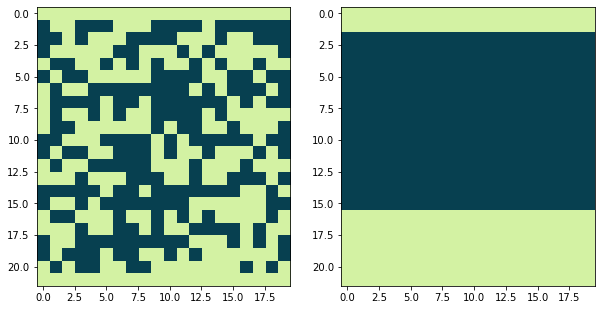

In [70]:
plt.figure(figsize=(10, 10))
plt.subplot(121)
plt.imshow(init_lattice, cmap=emr)
plt.subplot(122)
plt.imshow(la_pp, cmap=emr)